In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

In [96]:
img_ = cv2.imread('right.jpg') #read image on the right
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY) #convert RGB image to Grayscale
img = cv2.imread('left.jpg') #read image on the left
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #convert RGB image to Grayscale

In [97]:
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None) #kp1 and kp2 are keypoints and des1 and des2 are the descriptors
kp2, des2 = sift.detectAndCompute(img2,None)

In [98]:
plt.rcParams["figure.figsize"] = [16,10]
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img_,kp1,None), cv2.COLOR_BGR2RGB)) #draw the keypoints on the image
cv2.imwrite("keypoints.jpg", cv2.drawKeypoints(img_,kp1,None)) #save image to local computer

True

In [99]:
#here i am using BFMatcher(), which matches the features that are more similar
#when we set parameter k=2, we are asking the knnMatcher to give out 2 best matches for each descriptor
#i could have used FLANN matcher instead of BFMatcher, but the results would be the same

match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2, k=2)

In [100]:
#we apply ratio test using the top 2 matches obtained above to get the best one
#we consider a match if the ratio defined below is greater than the specified ratio
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
        matches = np.asarray(good)

In [101]:
#align the images using the homography matrix

if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    print(H)
else:
    raise AssertionError("Canâ€™t find enough keypoints.")

[[ 9.99655818e-01 -7.29761440e-05  2.66499853e+03]
 [-1.04783433e-04  9.99929965e-01  3.94966816e-02]
 [-1.10916858e-07 -2.79003704e-08  1.00000000e+00]]


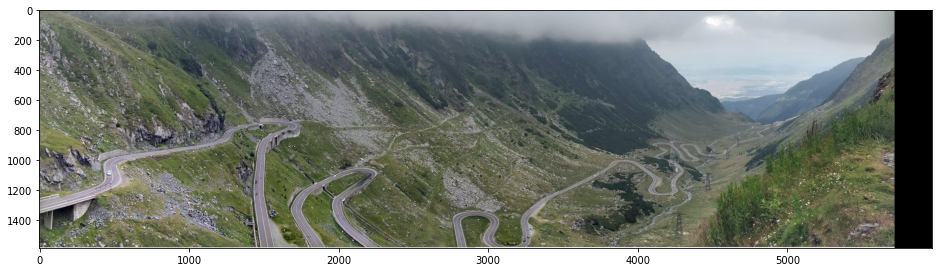

In [102]:
#now that we found the homography for transformation, we can now proceed to warp and stitch the images together

dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
plt.subplot(122),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Warped Image') 
cv2.imwrite('warped.jpg',dst)
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img
cv2.imwrite('output.jpg',dst)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

#used cv2.cvtColor(dst, cv2.COLOR_BGR2RGB) because plt is using BGR instead of RGB 
#and cv2.imshow can not be used inline with jupyter

In [103]:
#trim all the black edges
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

True

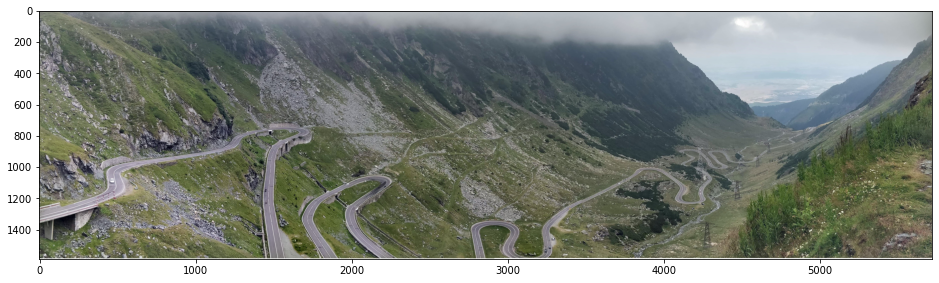

In [106]:
#cv2.imshow("final_output.jpg", trim(dst))

plt.imshow(cv2.cvtColor(trim(dst), cv2.COLOR_BGR2RGB))
cv2.imwrite("final_output.jpg", trim(dst))